In [ ]:
'''This is a travel exercise. I have a file with flight data for 60 days.
I want to answer the question of how much one should pay for a flight from Boston to Cancun.
Metadata:
fields: 
- messageid : { type: string, comment: 'Unique ID for trip bundle'}
- tripindex : { type: integer, comment: 'Within-bundle trip count, from 0'}
- received : { type: date, format: epoch-seconds }
- currency : { type: string, tags: [categorical], comment: 'Convert prices via currency xref' }
- total : { type: real }
- tax : { type: real }
- surcharge : { type: real }
- source : { type: string, tags: [categorical] }
- merchant : { type: string, tags: [categorical], comment: 'Ticketing authority' }
- majorcarrierid: {type: string, tags: [categorical], comment: 'Ticketing airline' }
- origin : { type: string, tags: [categorical], comment: 'Three letter IATA airport code' }
- destination : { type: string, tags: [categorical], comment: 'Three letter IATA airport code' }
- departure : { type: date, format: epoch-seconds, comment: 'UTC time of departure (convert to origin TZ to get local departure time)' }
- return : { type: date, format: epoch-seconds, comment: 'UTC time of departure (convert to destination TZ to get local return time)' }
- los2 : { type: integer, comment: 'Difference between yyyymmdd of departure in local time at origin and yyyymmdd of return in local time at destination.' }
- outbounddurationminutes : { type: integer }
- outboundstops : { type : integer }
- returndurationminutes : { type : integer }
- returnstops : { type : integer }
- availableseats : { type : integer }
- cabinclass : { type: string, tags: [categorical], values: [E, B, F], comment: 'Economy, business or first class' }
- paxtype : { type: string, tags: [categorical] }
- refundable : { type: boolean, comment: 'Indicates refundable ticket' }
- triptimestamp : { type: date, format: epoch-seconds, comment: 'When this query result was generated (UTC)' }
- receiveddate : { type: date, format: yyyymmdd, comment: 'Day message received at Hopper. Hive table is partitioned on this value' }'''

In [1]:
# I import the modules I will need.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Firstly, I read the data.
flights = pd.read_csv("BOS_CUN_trips1M.csv",)
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


In [3]:
# I now want to see all the  column names.
flights.columns

Index([u'messageid', u'tripindex', u'received', u'currency', u'total', u'tax',
       u'surcharge', u'source', u'merchant', u'majorcarrierid', u'origin',
       u'destination', u'departure', u'return', u'outbounddurationminutes',
       u'outboundstops', u'returndurationminutes', u'returnstops',
       u'availableseats', u'cabinclass', u'paxtype', u'refundable',
       u'triptimestamp', u'receiveddate', u'received_odate',
       u'departure_odate', u'return_ddate', u'los2', u'departure_dow',
       u'return_dow', u'includes_sns'],
      dtype='object')

In [4]:
# I want to get some basic information about the flights DataFrame
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202445 entries, 0 to 1202444
Data columns (total 31 columns):
messageid                  1202445 non-null object
tripindex                  1202445 non-null int64
received                   1202445 non-null int64
currency                   1202445 non-null object
total                      1202445 non-null float64
tax                        1202445 non-null float64
surcharge                  1202445 non-null float64
source                     1202445 non-null object
merchant                   1202445 non-null object
majorcarrierid             1202445 non-null object
origin                     1202445 non-null object
destination                1202445 non-null object
departure                  1202445 non-null int64
return                     1202445 non-null int64
outbounddurationminutes    1202445 non-null int64
outboundstops              1202445 non-null int64
returndurationminutes      1202445 non-null int64
returnstops             

/Users/katarzynarachuta/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2125: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


'I noticed one very obvious outlier at ~$6,500\n75%  of the tickets are under around ~$1250'

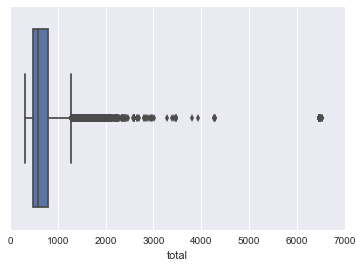

In [5]:
'''I now want to quick visualise the data using a box plot
This will help me to see how the data are spread out.
Here I make the assumption that the total includes the tax.'''

sns.boxplot(flights['total'], vert=False)

'''I noticed one very obvious outlier at ~$6,500
75%  of the tickets are under around ~$1250'''

(array([  3.69275000e+05,   4.02028000e+05,   1.76229000e+05,
          1.10833000e+05,   6.60720000e+04,   4.90930000e+04,
          1.95260000e+04,   7.10100000e+03,   1.57200000e+03,
          3.33000000e+02,   2.05000000e+02,   1.80000000e+01,
          9.00000000e+00,   4.00000000e+00,   9.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.24000000e+02]),
 array([  320.37      ,   497.60914286,   674.84828571,   852.08742857,
         1029.32657143,  1206.56571429,  1383.80485714,  1561.044     ,
         1738.28314286,  1915.52228571,  2092.76142857,  2270.00057143,
         2447.23971429,  2624.47885714,  2801.718     , 

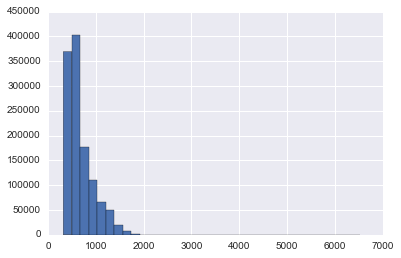

In [6]:
'''One last viualisation is a histogram. 
I played around witht the number of bins and decided to stick to 35 as this produces a clear picture.'''

plt.hist(flights['total'], bins=35)

(array([  1.70000000e+03,   3.43490000e+04,   1.08253000e+05,
          1.03648000e+05,   9.39940000e+04,   9.47580000e+04,
          8.23930000e+04,   7.78260000e+04,   7.75220000e+04,
          6.76010000e+04,   4.94840000e+04,   4.35420000e+04,
          2.95500000e+04,   3.42650000e+04,   2.70490000e+04,
          2.36180000e+04,   2.75910000e+04,   2.76190000e+04,
          1.92230000e+04,   1.86750000e+04,   1.47200000e+04,
          1.04230000e+04,   1.30620000e+04,   1.26590000e+04,
          1.54020000e+04,   1.13250000e+04,   1.06140000e+04,
          1.39430000e+04,   1.09710000e+04,   6.61300000e+03,
          7.38300000e+03,   5.17300000e+03,   3.49000000e+03,
          4.71100000e+03,   3.58600000e+03,   3.65500000e+03,
          2.67100000e+03,   1.91600000e+03,   9.98000000e+02,
          1.19400000e+03,   1.54600000e+03,   1.36900000e+03,
          3.87000000e+02,   6.13000000e+02,   2.76000000e+02,
          1.68000000e+02,   9.90000000e+01,   1.61000000e+02,
        

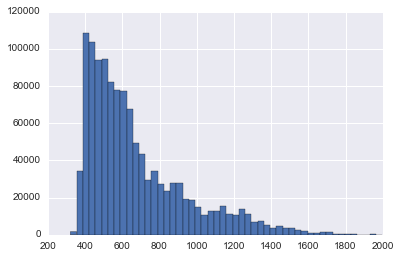

In [7]:
'''It seems to me that it would make sense to visualise the data for prices below $2,000.
This will allow me to see better the distribution around those lower values as it seems
to me that a lot of lower priced flights are there.'''

flights2 = flights[flights['total'] < 2000]

plt.hist(flights2['total'], bins=50)

In [8]:
'''I have now seen how the data are distributed.
I want to get now the actual numbers for the mean and quartiles.'''

flights_price = flights['total']
flights_price = pd.DataFrame(flights_price)
flights_price.describe()

,total
count,1.202445e+06
mean,6.742877e+02
std,2.787050e+02
min,3.203700e+02
25%,4.719500e+02
50%,5.913700e+02
75%,7.933700e+02
max,6.523740e+03


In [ ]:
'''This means that the mean price is ~$674, we will pay the minimum of $320. 
50% of the flights cost $591 or less and 75% of the flights cost $793 or less.
The most expensive flight was at $6523.74
the cabin class - I would expect the flights to be expensive for first class and cheapest for the economy class
the number of stopovers - I expect direct flights to be most expensive
refundable/non-refundable tickets - I would expect the latter to be cheaper
airline - some airlines will be more expensive than others
date booked - booking really far ahead and really close to the departure date should be expensive
travel time - some times will be cheaper than others
day of the week when we searched for the prices - usually it is recommended that you book a flight on a Tuesday and
avoid booking on a Friday.
I will now test these hypotheses.
'''

In [ ]:
'''Firstly, I want to look at the different flight prices for the different cabin classes.'''

In [9]:
# I first look at the economy class.
economy = flights[flights['cabinclass'] == 'E']
economy.head()
# 1201004 rows × 31 columns

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


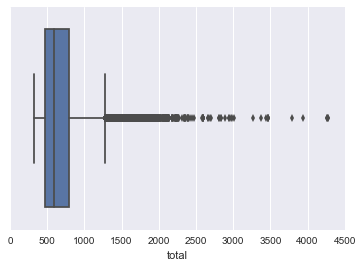

In [10]:
# I now want to visualise the economy data.
sns.boxplot(economy['total'], vert=False)

In [11]:
'''From the box plot above, I can see how the data are spread out. I now want to find the exact numbers for 
the mean, quartiles etc.
I am surprised to see that 25% of the tickets are above $1,250.'''

economytotal = economy['total'].describe()
economytotal = pd.DataFrame(economytotal)
economytotal
'''I can see that for an economy flight, we won't pay more than ~$4278, with the mean value being $674 
and median being $591.
The standard deviation is high at $272 (its almost half the mean).'''

,total
count,1.201004e+06
mean,6.735797e+02
std,2.724485e+02
min,3.203700e+02
25%,4.719500e+02
50%,5.909500e+02
75%,7.933700e+02
max,4.278770e+03


In [12]:
# I now want to look at business class flights
business = flights[flights['cabinclass'] == 'B']
business.head()
# 1041 rows × 31 columns

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
20173,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,424,1380001461,USD,599.27,119.27,0.0,Amadeus,FL,FL,...,False,1380001461,20130924,2013-09-23,2013-11-23,2013-11-25,2,6,1,1
20174,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,425,1380001461,USD,599.27,119.27,0.0,Amadeus,FL,FL,...,False,1380001461,20130924,2013-09-23,2013-11-23,2013-11-28,5,6,4,1
23629,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,988,1380526749,USD,1240.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-16,2013-12-01,15,6,0,1
23631,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,986,1380526749,USD,1081.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-17,2013-11-30,13,0,6,1
23635,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,982,1380526749,USD,975.37,101.37,0.0,Amadeus,UA,UA,...,False,1380526749,20130930,2013-09-29,2013-11-15,2013-11-30,15,5,6,1


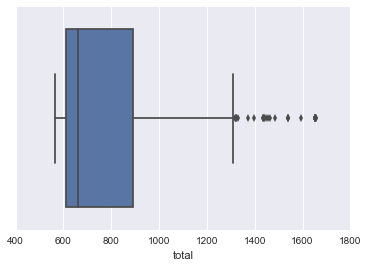

In [13]:
# As above, I want to use a box plot to visualise the data.
sns.boxplot(business['total'], vert=False)

In [14]:
'''For the business class tickets, I can see that there is a relatively big difference between the median
and the fourth quartile.'''

businesstotal = business['total'].describe()
businesstotal = pd.DataFrame(businesstotal)
businesstotal
'''For a business flight, the mean flight price is $786 and the median is $659
and I shouldnt expect to pay more than $1658.
Again, the standard deviation is quite high at $245.
I am surprised that the maximum price is $1658 - it seems relatively low to me. Same goes for the mean and
the median, I was expecting them to be much higher.'''

,total
count,1041.000000
mean,786.415043
std,245.655838
min,562.570000
25%,608.850000
50%,659.180000
75%,892.170000
max,1657.950000


In [15]:
# Finally, I look at first class flights.

first = flights[flights['cabinclass'] == 'F']
first.head()
# 276 rows × 31 columns - not much information.

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
21108,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1076,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-21,10,5,1,1
21109,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1077,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-26,15,5,6,1
21130,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1098,1380001461,USD,683.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-18,7,5,5,1
21131,11d548da24b2a342000001414e7f330828c6951ee8d33c5a,1099,1380001461,USD,703.37,115.37,0.0,Amadeus,AA,AA,...,False,1380001461,20130924,2013-09-23,2013-10-11,2013-10-19,8,5,6,1
23564,3248dfa1a07f76fe000001416dce75480166920c4c89ca56,1053,1380526749,USD,629.37,115.37,0.0,Amadeus,DL,DL,...,False,1380526749,20130930,2013-09-29,2013-11-14,2013-11-29,15,4,5,1


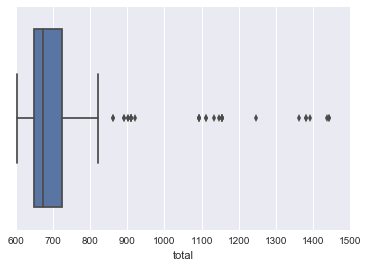

In [16]:
# As above, I want to use a box plot to visualise the data.
sns.boxplot(first['total'], vert=False)

In [17]:
'''Again, I can see the distribution, which is much less spread out that the distribution for the business tickets.
I want to look at the quick stats and find the actual numbers for the mean and quartiles.'''

firsttotal = first['total'].describe()
firsttotal = pd.DataFrame(firsttotal)
firsttotal
'''On average, I should be looking at paying $726, with the median being $673.
I shouldnt pay more than $1441 per flight. Standard deviation is lowest at only $161 - which
means that my observation that the data is the least spread out compared to other tickets is true'''

,total
count,276.000000
mean,726.727464
std,161.349212
min,604.370000
25%,648.950000
50%,673.370000
75%,725.950000
max,1441.370000


In [18]:
'''I discovered that there is a fourth class in the cabinclass column and its called EP.
I cant find what it means so I decide to exclude it from this analysis.'''

flights2 = flights[flights['cabinclass'] != 'EP']

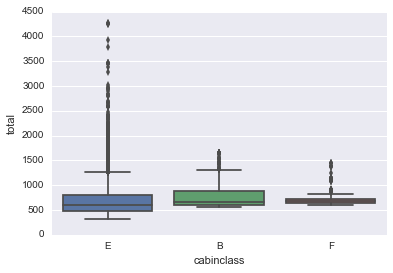

In [20]:
'''Having the plots separately means that it is not easy to compare them. I now want to plot all three box plots
next to each other to see how that compares'''

sns.boxplot(flights2['cabinclass'], flights2['total'])
'''As expected, I can see the economy prices start at lowest values. But they are also really spread - especially
all of the prices above the third quartile. In comparison, first class tickets are very 'condensed'.
Again, please note that I used the total price and I am not sure if it includes tax.'''

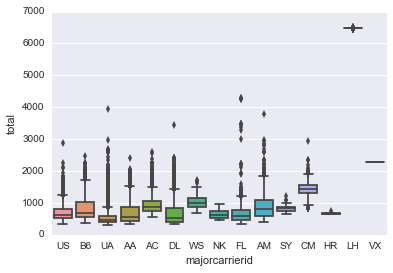

In [21]:
# I now want to look at the pricing distributions by different airlines. I first do a visualisation.

sns.boxplot(flights['majorcarrierid'], flights['total'])

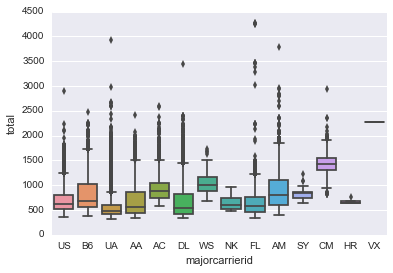

In [24]:
'''I can see there is something odd happening with LH. I will exclude this as this is very clearly an outlier.
UA (United) Airlines are on the cheaper side (but has a lot of outliers).
HR (Hahn Air) has a very narrow spread of the price differences. 
'''
airlines = flights[flights['majorcarrierid'] != 'LH']
sns.boxplot(airlines['majorcarrierid'], airlines['total'])

In [25]:
'''The second visualisation is much clearer. I can now see that HR has a very small distribution of flight prices,
and so does VX where the flight prices are very narrow.'''

# I now want to sort the data by the different airlines, i.e. majorcarrierid
# I then find the mean flight price
meanprice = flights.groupby('majorcarrierid').mean()
meanpricedf = pd.DataFrame(meanprice['total'])
meanpricedf.sort_values(by='total')
'''We can now see how these prices are different. For example, the cheapest major carrier on average is UA,
the most expensive carrier by the average price is LH'''

,total
majorcarrierid,
UA,540.865941
FL,626.696252
NK,651.178757
DL,664.189529
HR,673.265000
AA,687.301207
US,692.882309
B6,801.564038
SY,817.057615


In [26]:
'''I now want to look at the different flight prices for refundable and non-refundable flights. I am going to start
with refundable flights first.'''
refundableflights = flights[flights['refundable'] == True]
refundableflights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
861,2c89c1ab745aec26000001410e399ab3aa9fe4728648ad8b,45,1378923158,USD,1251.57,116.57,0.0,Sabre,TCY,AM,...,True,1378923158,20130911,2013-09-11,2014-07-10,2014-07-18,8,4,5,1
947,3dc7cac49ef4382f000001410d1a5a260697a02b899615e0,37,1378904332,USD,930.57,116.57,0.0,Sabre,TCY,AM,...,True,1378904332,20130911,2013-09-11,2013-09-22,2013-09-29,7,0,0,1
1020,42e64275e7bb0edd000001410d102090ecb3e2ded758ba6f,17,1378903662,USD,930.57,116.57,0.0,Sabre,TCY,AM,...,True,1378903662,20130911,2013-09-11,2013-10-11,2013-10-19,8,5,6,1
1448,b54624dc6c91bc1e00000141e5685bb04257f803208eafb6,35,1382533323,USD,1495.15,112.15,0.0,Sabre,TCY,AM,...,True,1382533323,20131023,2013-10-23,2014-04-19,2014-04-26,7,6,6,1
1450,b54624dc6c91bc1e00000141e5685bb04257f803208eafb6,33,1382533323,USD,980.15,126.15,0.0,Sabre,TCY,AM,...,True,1382533323,20131023,2013-10-23,2014-04-19,2014-04-26,7,6,6,1


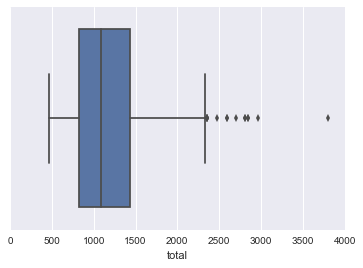

In [27]:
# I now want to visualise the price spread of the refundable tickets.
sns.boxplot(refundableflights['total'], vert=False)
# I can see that 75% of the refundable tickets are below $2,4000.

In [28]:
# I now run quick statistics on the refundable ticket prices.

refundableflights = refundableflights['total'].describe()
refundableflights = pd.DataFrame(refundableflights)
refundableflights

,total
count,7924.000000
mean,1145.334387
std,408.931065
min,466.170000
25%,826.950000
50%,1089.150000
75%,1436.570000
max,3794.570000


In [29]:
# Now I want to look at the non-refundable flights.

nrefundableflights = flights[flights['refundable'] == False]
nrefundableflights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,refundable,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,False,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1


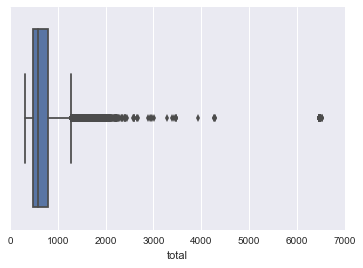

In [30]:
# I now want to visualise the price spread of the non-refundable tickets.

sns.boxplot(nrefundableflights['total'], vert=False)
# I can see that 75% of the non-refundable flights are below $1,250.

In [31]:
# Similarly as above, I'm running the quick statistics.
nrefundableflights = nrefundableflights['total'].describe()
nrefundableflights = pd.DataFrame(nrefundableflights)
nrefundableflights

,total
count,1.194521e+06
mean,6.711629e+02
std,2.749562e+02
min,3.203700e+02
25%,4.713700e+02
50%,5.893700e+02
75%,7.894500e+02
max,6.523740e+03


'As expect, the refundable flights are more expensive. However, I am surprised by the fact that the\nnon-refundable flights have quite a lot of expenisve outliers.'

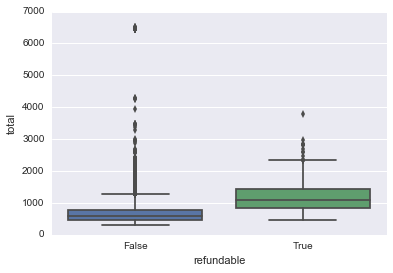

In [32]:
# Now I'm going to produce the two box plots side by side to allow for comparison.
sns.boxplot(flights['refundable'], flights['total'])
'''As expect, the refundable flights are more expensive. However, I am surprised by the fact that the
non-refundable flights have quite a lot of expenisve outliers.'''

In [33]:
'''I will now look at the different number of stopovers and see how the prices are spread here.
I want to group by both the number of outbound stops and return stops. I then find mean prices.'''
groupedflights = flights.groupby(['outboundstops', 'returnstops']).mean()
groupedflights = pd.DataFrame(groupedflights['total'])
groupedflights
# Again, I'm only interested in the 'total' column.

total
outboundstops returnstops            
0             0            956.847618
              1            826.761802
              2            775.938667
1             0            781.470335
              1            651.233799
              2            638.635024
              3            489.361429
2             0            758.911642
              1            635.264192
              2            611.120183
              3            470.450000
3             0            768.576612
              1            726.988780
              2            647.720327

In [34]:
# I want to pivot this table. First I need to do export-import

groupedflights.to_csv("number_of_stopovers.csv")
number_of_stopovers = pd.read_csv("number_of_stopovers.csv")
number_of_stopoverspiv = number_of_stopovers.pivot("outboundstops", "returnstops", "total")
number_of_stopoverspiv

returnstops,0,1,2,3
outboundstops,,,,
0,956.847618,826.761802,775.938667,NaN
1,781.470335,651.233799,638.635024,489.361429
2,758.911642,635.264192,611.120183,470.450000
3,768.576612,726.988780,647.720327,NaN


In [ ]:
'''We can see that on average, a trip with both no outbound stops and no return stops is the most expensive.
This is not surprising. We can also see that the cheapest flight combination is with 2 outbound stops 
and 3 return stops.
'''

In [35]:
'''I now want to work out what is the best day of the week to book the flight.
Firstly, I only take some specific columns from the flights DataFrame.
'''
dates = flights[['departure', 'return', 'triptimestamp', 'total']]
dates.head()

,departure,return,triptimestamp,total
0,1394789400,1395503700,1382317607,631.45
1,1394829000,1395498600,1382317607,632.95
2,1394804580,1395518400,1382317607,620.95
3,1394789400,1395498600,1382317607,632.95
4,1394789400,1395518400,1382317607,565.95


In [36]:
# First, I need to convert the dates into floats in order to be able to do anything with them later. I used
# df.dtypes to ensure I have converted all of the values into floats.
dates = dates.astype(float)
dates.dtypes

departure        float64
return           float64
triptimestamp    float64
total            float64
dtype: object

In [37]:
# I now can convert epoch time (in seconds) into UCT.

dates['triptimestamp'] = pd.to_datetime(dates['triptimestamp'], unit='s')
dates['departure'] = pd.to_datetime(dates['departure'], unit='s')
dates['return'] = pd.to_datetime(dates['return'], unit='s')
dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [38]:
# Firstly, I convert all the dates into strings that I can parse
dates['departure'] = dates['departure'].astype(str)
dates['return'] = dates['return'].astype(str)
dates['triptimestamp'] = dates['triptimestamp'].astype(str)

dates.head()

,departure,return,triptimestamp,total
0,2014-03-14 09:30:00,2014-03-22 15:55:00,2013-10-21 01:06:47,631.45
1,2014-03-14 20:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
2,2014-03-14 13:43:00,2014-03-22 20:00:00,2013-10-21 01:06:47,620.95
3,2014-03-14 09:30:00,2014-03-22 14:30:00,2013-10-21 01:06:47,632.95
4,2014-03-14 09:30:00,2014-03-22 20:00:00,2013-10-21 01:06:47,565.95


In [39]:
# I now want to take each column and convert it into a Series so I can parse strings in each of them.
# I then concatenate them back together.

departuredates = dates['departure']
returndates = dates['return']
timestamp = dates['triptimestamp']
datestotal = dates['total']

departuredates = pd.Series(departuredates)
returndates = pd.Series(returndates)
timestamp = pd.Series(timestamp)

departuresplit = departuredates.str.split(' ', expand=True)
returndatesplit = returndates.str.split(' ', expand=True)
timestampsplit = timestamp.str.split(' ', expand=True)

departuresplit.columns = 'departure dates', 'departure times'
returndatesplit.columns = 'return dates', 'return times'
timestampsplit.columns = 'timestamp dates', 'timestamp times'

frames = [departuresplit, returndatesplit, timestampsplit, datestotal]

concat = pd.concat(frames, axis=1, join_axes=[departuresplit.index])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95


In [40]:
# I now want to find the day of the week on the timestamp to then work out day of the week.

concat['timestamp dates'] = pd.to_datetime(concat['timestamp dates'])
concat['day_of_week'] = concat['timestamp dates'].dt.dayofweek

days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}

concat['day_of_week'] = concat['day_of_week'].apply(lambda x: days[x])

concat.head()

,departure dates,departure times,return dates,return times,timestamp dates,timestamp times,total,day_of_week
0,2014-03-14,09:30:00,2014-03-22,15:55:00,2013-10-21,01:06:47,631.45,Mon
1,2014-03-14,20:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
2,2014-03-14,13:43:00,2014-03-22,20:00:00,2013-10-21,01:06:47,620.95,Mon
3,2014-03-14,09:30:00,2014-03-22,14:30:00,2013-10-21,01:06:47,632.95,Mon
4,2014-03-14,09:30:00,2014-03-22,20:00:00,2013-10-21,01:06:47,565.95,Mon


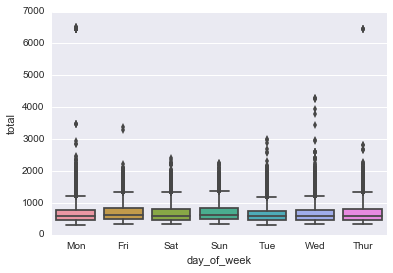

In [41]:
# I now produce a quick visualisation to see when it's best to book the flight.

sns.boxplot(concat['day_of_week'], concat['total'])

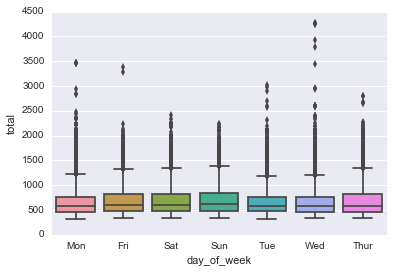

In [43]:
'''I can see that the two furthest outliers are above $6,000. I want to see close the distribution so I will
just look at the data with prices below $5,000'''

concat2 = concat[concat['total'] < 6000]
sns.boxplot(concat2['day_of_week'], concat2['total'])

In [44]:
# I now want to see the mean price for each day of the week.

concat.groupby('day_of_week').mean()
# I can see that the flights are marginally cheaper on Mondays and Tuesdays. I am surprised that the difference is quite
# small.

,total
day_of_week,
Fri,695.859330
Mon,658.797686
Sat,683.030484
Sun,699.856178
Thur,678.577925
Tue,658.865848
Wed,659.666595


In [45]:
'''The next step is to look at the different days of the week to depart and return and what difference that
makes if it comes to pricing.

I want to now look at the column with departure dates i.e. departure_odate.
I then want to convert that into a day of the week.''' 

flights['departure_odate'] = pd.to_datetime(flights['departure_odate'])
flights['day_of_week_dep'] = flights['departure_odate'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
flights['day_of_week_dep'] = flights['day_of_week_dep'].apply(lambda x: days[x])
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,triptimestamp,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns,day_of_week_dep
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,1382317607,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri


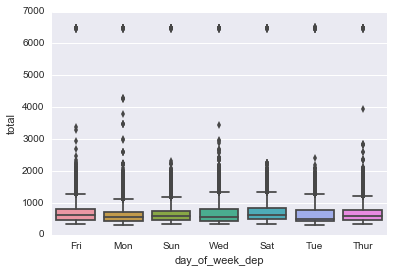

In [46]:
# I create quick visualisations to see the price spread.

sns.boxplot(flights['day_of_week_dep'], flights['total'])

In [47]:
# I can now group the table by the day of the week departure and find mean prices for each day of the week to depart.

grouped = flights.groupby('day_of_week_dep').mean()
groupeddf = pd.DataFrame(grouped['total'])
groupeddf.sort_values('total')

# As expected, the most expensive days to travel are Friday and Saturday. The cheapest are Tuesday and Monday.

,total
day_of_week_dep,
Tue,626.971564
Mon,627.900513
Sun,651.500564
Thur,673.033312
Wed,677.623847
Fri,685.179145
Sat,707.917809


In [48]:
# I now do the same thing for the return day of the week.

flights['return_ddate'] = pd.to_datetime(flights['return_ddate'])
flights['day_of_week_ret'] = flights['return_ddate'].dt.dayofweek
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thur',4:'Fri',5:'Sat',6:'Sun'}
flights['day_of_week_ret'] = flights['day_of_week_ret'].apply(lambda x: days[x])
flights.head()

,messageid,tripindex,received,currency,total,tax,surcharge,source,merchant,majorcarrierid,...,receiveddate,received_odate,departure_odate,return_ddate,los2,departure_dow,return_dow,includes_sns,day_of_week_dep,day_of_week_ret
0,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,12,1382317607,USD,631.45,123.45,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
1,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,11,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
2,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,10,1382317607,USD,620.95,124.95,0.0,Sabre,TCY,B6,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
3,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,9,1382317607,USD,632.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat
4,f4f57b70aaf2f56600000141d88ccbb0294a88500186aea5,8,1382317607,USD,565.95,124.95,0.0,Sabre,TCY,US,...,20131021,2013-10-20,2014-03-14,2014-03-22,8,5,6,1,Fri,Sat


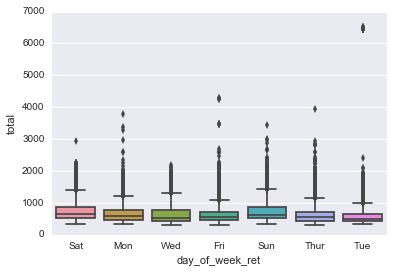

In [49]:
# Again, I do a quick visualisation.
sns.boxplot(flights['day_of_week_ret'], flights['total'])

In [50]:
# Similar to above, I group the table by the day of the week return and find mean prices.

grouped2 = flights.groupby('day_of_week_ret').mean()
groupeddf2 = pd.DataFrame(grouped2['total'])
groupeddf2.sort_values('total')

# Again, the cheapest day of the week to return is Tuesday and 2nd is Saturday.
# Most expensive days to return are Sunday (unsurprising) and Saturday.

,total
day_of_week_ret,
Tue,587.906721
Fri,618.192966
Thur,635.998165
Mon,649.161847
Wed,651.201279
Sat,724.506405
Sun,735.317349


In [51]:
# I now group the table by both departure day of the week and return day of the week.

grouped3 = flights.groupby(['day_of_week_dep', 'day_of_week_ret']).mean()
grouped3df = pd.DataFrame(grouped3['total'])
grouped3df

total
day_of_week_dep day_of_week_ret            
Fri             Fri              648.313314
                Mon              671.862519
                Sat              783.742975
                Sun              703.458688
                Thur             669.397004
                Tue              612.570156
                Wed              754.278957
Mon             Fri              590.641378
                Mon              601.709979
                Sat              644.547527
                Sun              710.861894
                Thur             609.977553
                Tue              559.276708
                Wed              707.557244
Sat             Fri              664.001598
                Mon              678.835879
                Sat              731.627285
                Sun              686.599597
                Thur             638.343448
                Tue              583.994101
                Wed              689.127320
Sun             Fri              575.593330
                Mon              664.462996
                Sat              668.789391
                Sun              719.301648
                Thur             578.913307
                Tue              562.964301
                Wed              565.540041
Thur            Fri              640.614428
                Mon              669.787813
                Sat              702.324744
                Sun              734.055653
                Thur             672.078664
                Tue              630.974115
                Wed              669.317431
Tue             Fri              521.283394
                Mon              571.833854
                Sat              705.563544
                Sun              729.692373
                Thur             617.574370
                Tue              531.764000
                Wed              728.836896
Wed             Fri              575.008254
                Mon              683.745347
                Sat              798.385233
                Sun              834.310144
                Thur             585.582222
                Tue              632.317329
                Wed              551.575495

In [52]:
# Now I want to create a pivot table with the data.

grouped3df.to_csv("grouped3df.csv")
grouped3df = pd.read_csv("grouped3df.csv")
grouped3df = grouped3df[['day_of_week_dep', 'day_of_week_ret', 'total']]
pivot_table = grouped3df.pivot('day_of_week_dep', 'day_of_week_ret', 'total')
pivot_table

day_of_week_ret,Fri,Mon,Sat,Sun,Thur,Tue,Wed
day_of_week_dep,,,,,,,
Fri,648.313314,671.862519,783.742975,703.458688,669.397004,612.570156,754.278957
Mon,590.641378,601.709979,644.547527,710.861894,609.977553,559.276708,707.557244
Sat,664.001598,678.835879,731.627285,686.599597,638.343448,583.994101,689.127320
Sun,575.593330,664.462996,668.789391,719.301648,578.913307,562.964301,565.540041
Thur,640.614428,669.787813,702.324744,734.055653,672.078664,630.974115,669.317431
Tue,521.283394,571.833854,705.563544,729.692373,617.574370,531.764000,728.836896
Wed,575.008254,683.745347,798.385233,834.310144,585.582222,632.317329,551.575495


In [53]:
# I want to re-order the columns so they start with Monday and finish with Sunday.

pivot_table = pivot_table[['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']]
pivot_table

day_of_week_ret,Mon,Tue,Wed,Thur,Fri,Sat,Sun
day_of_week_dep,,,,,,,
Fri,671.862519,612.570156,754.278957,669.397004,648.313314,783.742975,703.458688
Mon,601.709979,559.276708,707.557244,609.977553,590.641378,644.547527,710.861894
Sat,678.835879,583.994101,689.127320,638.343448,664.001598,731.627285,686.599597
Sun,664.462996,562.964301,565.540041,578.913307,575.593330,668.789391,719.301648
Thur,669.787813,630.974115,669.317431,672.078664,640.614428,702.324744,734.055653
Tue,571.833854,531.764000,728.836896,617.574370,521.283394,705.563544,729.692373
Wed,683.745347,632.317329,551.575495,585.582222,575.008254,798.385233,834.310144


In [54]:
# I have to do the same for the rows.

pivot_table = pivot_table.reindex(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
pivot_table

day_of_week_ret,Mon,Tue,Wed,Thur,Fri,Sat,Sun
day_of_week_dep,,,,,,,
Mon,601.709979,559.276708,707.557244,609.977553,590.641378,644.547527,710.861894
Tue,571.833854,531.764000,728.836896,617.574370,521.283394,705.563544,729.692373
Wed,683.745347,632.317329,551.575495,585.582222,575.008254,798.385233,834.310144
Thur,669.787813,630.974115,669.317431,672.078664,640.614428,702.324744,734.055653
Fri,671.862519,612.570156,754.278957,669.397004,648.313314,783.742975,703.458688
Sat,678.835879,583.994101,689.127320,638.343448,664.001598,731.627285,686.599597
Sun,664.462996,562.964301,565.540041,578.913307,575.593330,668.789391,719.301648


In [ ]:
'''I can now see the different price combinations for different days of the week outbound and return.'''